# Split Chosen AoI Shapes into Grid Patches

The FloodMapper system requires area-of-interest (AoI) shapes that have been resampled by the fixed grid of processing 'patches' defined in the database. This notebook demonstrates how transform arbitrary AoI shapes into a GeoJSON file suitable for use with FloodMapper.

In [2]:
# Necessary Python modules
import sys
import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import geopandas as gpd
import folium

from dotenv import load_dotenv
from db_utils import DB
from ml4floods.data import utils

# Set bucket will not be requester pays
utils.REQUESTER_PAYS_DEFAULT = False

## Load environment and project details

As with the other notebooks, we load credentials and project details from a hidden ```.env``` file.

In [3]:
# Load environment variables (including path to credentials) from '.env' file
env_file_path = "../.env" 

# Uncomment for alternative version for Windows (r"" indicates raw string)
#env_file_path = r"C:/Users/User/floodmapper/.env"

assert load_dotenv(dotenv_path=env_file_path) == True, "[ERR] Failed to load environment!"
assert "GOOGLE_APPLICATION_CREDENTIALS" in os.environ, "[ERR] Missing $GOOGLE_APPLICATION_CREDENTIAL!"
assert "GS_USER_PROJECT" in os.environ, "[ERR] Missing $GS_USER_PROJECT!"
key_file_path = os.environ["GOOGLE_APPLICATION_CREDENTIALS"]
assert os.path.exists(key_file_path), f"[ERR] Google credential key file does not exist: \n{key_file_path} "
assert "ML4FLOODS_BASE_DIR" in os.environ, "[ERR] Missing $ML4FLOODS_BASE_DIR!"
base_path = os.environ["ML4FLOODS_BASE_DIR"]
assert os.path.exists(base_path), f"[ERR] Base path does not exist: \n{base_path} "
bucket_name = os.environ["BUCKET_URI"]
assert bucket_name is not None and bucket_name != "", f"Bucket name not defined {bucket_name}"

print("[INFO] Successfully loaded FloodMapper environment.")

[INFO] Successfully loaded FloodMapper environment.


In [4]:
# Connect to the database (point to the .env file for credentials)
db_conn = DB(env_file_path)

[INFO] Connecting to DB 'floodmapper-db'.
[INFO] Connection successfully established.


## Select LGA shapes from the database

Define a list of LGA names to map and execute the cells below to load their shapes from the database.

In [7]:
# EDIT THIS CELL

# Set the list of LGA names to query
lga_names_lst = ["Boulia"]

# Set a session name
session_name = "boulia_test"

In [8]:
# Define and execute the query
query = (f"SELECT lga_name22, ST_AsText(geometry_col) "
         f"FROM lgas_info "
         f"WHERE lga_name22 IN %s;")
data = (tuple(lga_names_lst),)
aoi_df = db_conn.run_query(query, data, fetch=True)
print(f"[INFO] Returned {len(aoi_df)} rows.")

# Format the results into a correct GeoDataFrame
aoi_df['geometry'] = gpd.GeoSeries.from_wkt(aoi_df['st_astext'])
aoi_df.drop(['st_astext'], axis=1, inplace = True)
aoi_gdf = gpd.GeoDataFrame(aoi_df, geometry='geometry', crs="EPSG:4326")
aoi_gdf.head(3)

[INFO] Returned 1 rows.


,lga_name22,geometry
0,Boulia,"POLYGON ((137.99802 -22.76750, 137.99802 -22.7..."


## Visualise the AoIs to be mapped

The ```aoi_gdf``` dataframe contains a 'geometry' column with the boundaries of the LGAs, which we can visualise to confirm that they correspond to our previous selection.

In [9]:
# Plot the boundaries over OpenStreetMap layer
aoi_gdf.explore()

## Load the pre-defined grid of processing patches

Next we load the pre-defined grid of square processing patches from the FloodMapper database. To do this we define a Strutured Query Language (SQL - 'sequel') query to fetch the information.

In [10]:
# Define and execute the query
query = (f"SELECT patch_name, ST_AsText(geometry) "
         f"FROM grid_loc")
grid_df = db_conn.run_query(query, fetch= True)
print(f"[INFO] Returned {len(grid_df)} rows.")

# Format the results into a correct GeoDataFrame
grid_df['geometry'] = gpd.GeoSeries.from_wkt(grid_df['st_astext'])
grid_df.drop(['st_astext'], axis=1, inplace = True)
grid_gdf = gpd.GeoDataFrame(grid_df, geometry='geometry', crs="EPSG:4326")
grid_gdf.head(3)

[INFO] Returned 23834 rows.


,patch_name,geometry
0,GRID02419,"POLYGON ((115.91000 -33.60516, 115.91000 -33.3..."
1,GRID02420,"POLYGON ((115.91000 -33.40516, 115.91000 -33.1..."
2,GRID02420,"POLYGON ((115.91000 -33.40516, 115.91000 -33.1..."


<Axes: >

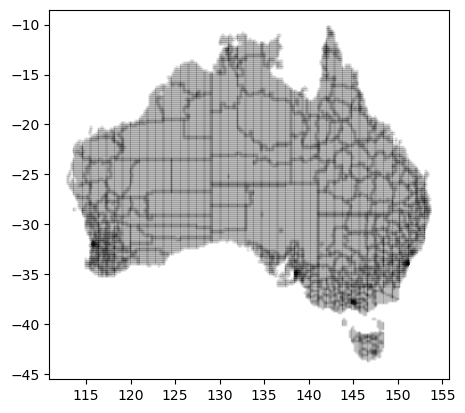

In [11]:
# Plot the grid as a sanity check
grid_gdf.plot(facecolor="none", lw=0.1)

## Use the AoIs to choose the grid patches to process

The next step is to filter the grid patches to be processed by choosing only those that overlap with the selected AoIs. 

In [12]:
# Do a spatial join to choose grid patches that overlap with AoIs
valid_names = grid_gdf.sjoin(aoi_gdf, how="inner")["patch_name"]
grid_selected_gdf = grid_gdf[grid_gdf.patch_name.isin(valid_names)]
grid_selected_gdf.drop_duplicates()
grid_selected_gdf.head(3)

,patch_name,geometry
12198,GRID21228,"POLYGON ((138.11000 -23.60516, 138.11000 -23.3..."
12199,GRID21228,"POLYGON ((138.11000 -23.60516, 138.11000 -23.3..."
12200,GRID21228,"POLYGON ((138.11000 -23.60516, 138.11000 -23.3..."


In [13]:
# Overplot the grid on the selected AOIs
m = aoi_gdf.explore(style_kwds={"fillOpacity": 0.1}, name="Selected AoIs")
grid_selected_gdf.explore(m=m, style_kwds={"fillOpacity": 0.0}, color="red", name="Grid")
folium.LayerControl(collapsed=False).add_to(m)
m

## Save the gridded AoIs to the GCP bucket

The Floodmapper system (including the three main scripts) is driven by a saved version of these selected grid patches. The final step is to save the the selection to a GeoJSON format file on the GCP bucket.

In [14]:
# Output filename
outfile = "patches_to_map.geojson"

# Form the session path and output path on the GCP bucket
session_path = os.path.join(bucket_name, "0_DEV/1_Staging/operational", 
                            session_name).replace("\\", "/")
outfile_path = os.path.join(session_path, outfile).replace("\\", "/")
print(f"[INFO] Will save selected grid patches to:\n\t{outfile_path}")

[INFO] Will save selected grid patches to:
	gs://floodmapper-demo/0_DEV/1_Staging/operational/boulia_test/patches_to_map.geojson


**Note down this path - the FloodMapper scripts will need to read this file on the command line.**

In [15]:
# ML4Floods provides a utility to write to the GCP bucket
utils.write_geojson_to_gcp(outfile_path, grid_selected_gdf)

In [16]:
# We can also check if the file was written successfully
fs = utils.get_filesystem(outfile_path)
success = fs.exists(outfile_path)
print(f"[INFO] Was file written successfully to GCP? -> {success}")

[INFO] Was file written successfully to GCP? -> True


Finally, we can also write the selection to a GeoJSON file on our local disk.

In [17]:
# Write the selected grid patches to local disk
folder_path = os.path.join(base_path, "flood-activations", session_name).replace("\\", "/")
outfile_path = os.path.join(folder_path, outfile).replace("\\", "/")
os.makedirs(folder_path, exist_ok=True)
grid_selected_gdf.to_file(outfile_path, driver="GeoJSON")
print(f"[INFO] Selected grid patches writen to:\n\t{outfile_path}")

[INFO] Selected grid patches writen to:
	/Users/cpurcell/Documents/PROJECT_FLOODS/ML4Floods_DEVELOPMENT/ML4Floods_Enhanced/FloodMapper_Deploy/flood-activations/boulia_test/patches_to_map.geojson


In [18]:
# Check that the file is on our local disk
!ls -l {folder_path}

total 184
-rw-r--r--  1 cpurcell  staff  93149 14 Apr 11:11 patches_to_map.geojson
